## Trainingsdaten vorbereiten
Die Bilder werden zunächst auf 50% runterskaliert um mögliche Mängel des Demosaic Verfahrens der Kamera zu verstecken. Dann wird das Bild nachträglich in eine Form gebracht die einem Bayer Sensor entspricht vor dem Demosaic Verfahren.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# filtermasken generator
from math import ceil

xtrans="""gbggrg
rgrbgb
gbggrg
grggbg
bgbrgr
grggbg
"""
bayer = """bg
gr"""

def filtermask_from_str(w,h,pattern=bayer):
    d = {"r":[1,0,0],"g":[0,1,0],"b":[0,0,1]}
    a = np.array([[d[y] for y in x] for x in pattern.splitlines()]).astype("float32")
    (ph,pw,_) = a.shape
    return np.tile(a,(ceil(h/ph),ceil(w/pw),1))[0:h,0:w]

In [3]:
from pathlib import Path
from PIL import Image
import numpy as np
from itertools import product

tile_size=32

train_a=[]
train_b=[]

for p in Path("./training_images").iterdir():
    if p.is_file():
        # bilder laden und in numpy array umwandeln
        im = Image.open(p).convert('RGB')
        # bild runterskalieren um effekte vom ursprünglichen demosaic verfahren zu minimieren
        im = im.resize((im.width//2,im.height//2),Image.LANCZOS)
        
        im_a = np.asarray(im,'float32')
        im_a/=255
        im_b= np.asarray(im,'float32')
        im_b/=255
        
        # Bayer Pattern erzeugen
        im_a*=filtermask_from_str(im.width,im.height)
        
        #Image.fromarray((im_a * 255).astype("uint8")).show()
        
        #bild aufteilen 
        (h,w,_) = im_a.shape
        (h,w) = (h//tile_size,w//tile_size)
        
        for x,y in product(range(w),range(h)):
            tile_a = im_a[y*tile_size:(y+1)*tile_size, x*tile_size:(x+1)*tile_size,].copy()
            train_a.append(tile_a)
            tile_b = im_b[y*tile_size:(y+1)*tile_size, x*tile_size:(x+1)*tile_size,].copy()
            train_b.append(tile_b)
            
        train_a = np.array(train_a)
        train_b = np.array(train_b)
        
        

### Mosaic zur Kontrolle anzeigen

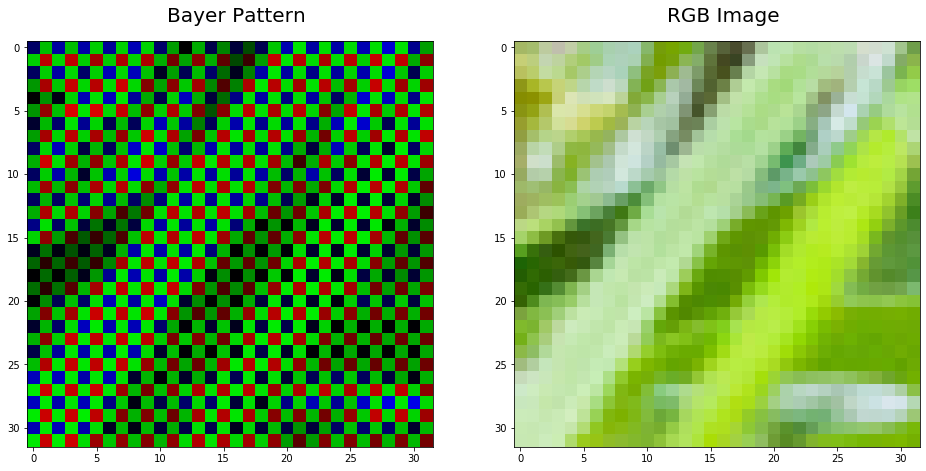

In [4]:
idx = 13

plt.figure(figsize=(16,16*2))
plt.subplot(1,2,1)
plt.imshow(train_a[idx],interpolation="nearest")
plt.text(16,-2,"Bayer Pattern",fontsize=20,horizontalalignment='center')
plt.subplot(1,2,2)
plt.imshow(train_b[idx],interpolation="nearest")
plt.text(16,-2,"RGB Image",fontsize=20,horizontalalignment='center')

plt.show()

## Modell erstellen

In [5]:
import keras
from keras.layers import Conv2D,Conv2DTranspose
from keras.models import Sequential
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


### Tensorflow soll sich nur den Speicher holen den es braucht anstatt sich alles unter den Nagel zu reißen
([Code aus Tensorflow Guide](https://www.tensorflow.org/guide/gpu#limiting_gpu_memory_growth))

In [6]:
from keras import backend as K

if K.backend() == 'tensorflow':
    import tensorflow as tf
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
      try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
      except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

 Hatte PSNRLoss in einem anderem Projekt benutzt und war besser als die builtin metrics

In [7]:
def PSNRLoss(y_true, y_pred):
    """
    PSNR is Peek Signal to Noise Ratio, which is similar to mean squared error.
    It can be calculated as
    PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
    When providing an unscaled input, MAXp = 255. Therefore 20 * log10(255)== 48.1308036087.
    However, since we are scaling our input, MAXp = 1. Therefore 20 * log10(1) = 0.
    Thus we remove that component completely and only compute the remaining MSE component.
    """
    return -10. * K.log(K.mean(K.square(y_pred - y_true))) / K.log(10.)

Vorerst nur ein sehr einfacher Autoencoder

In [8]:
model = Sequential()
model.add(Conv2D(64,(3,3), activation='relu', strides=(2, 2),padding='same',input_shape=(tile_size,tile_size,3)))
model.add(Conv2DTranspose(64,(3,3),activation='relu', strides=(2, 2), padding='same'))
model.add(Conv2DTranspose(3,(5,5),activation='linear',padding='same'))

model.compile(loss=keras.losses.mean_squared_error,
             optimizer=keras.optimizers.Adam(),
             metrics=[PSNRLoss])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 3)         4803      
Total params: 43,523
Trainable params: 43,523
Non-trainable params: 0
_________________________________________________________________


In [9]:
%%time

early_stopping = EarlyStopping(monitor='loss', patience=5)
hist =  model.fit(train_a, train_b,
                    batch_size=32,
                    epochs=200,
                    shuffle=True,
                    callbacks=[early_stopping],
                    verbose=2)

Epoch 1/200
 - 1s - loss: 0.1406 - PSNRLoss: 9.7329
Epoch 2/200
 - 1s - loss: 0.0405 - PSNRLoss: 13.9963
Epoch 3/200
 - 1s - loss: 0.0287 - PSNRLoss: 15.4628
Epoch 4/200
 - 1s - loss: 0.0195 - PSNRLoss: 17.1182
Epoch 5/200
 - 1s - loss: 0.0134 - PSNRLoss: 18.7404
Epoch 6/200
 - 1s - loss: 0.0090 - PSNRLoss: 20.4668
Epoch 7/200
 - 1s - loss: 0.0069 - PSNRLoss: 21.6571
Epoch 8/200
 - 1s - loss: 0.0059 - PSNRLoss: 22.3222
Epoch 9/200
 - 1s - loss: 0.0052 - PSNRLoss: 22.8701
Epoch 10/200
 - 1s - loss: 0.0046 - PSNRLoss: 23.4252
Epoch 11/200
 - 1s - loss: 0.0040 - PSNRLoss: 23.9616
Epoch 12/200
 - 1s - loss: 0.0036 - PSNRLoss: 24.4621
Epoch 13/200
 - 1s - loss: 0.0032 - PSNRLoss: 24.9717
Epoch 14/200
 - 1s - loss: 0.0029 - PSNRLoss: 25.4205
Epoch 15/200
 - 1s - loss: 0.0026 - PSNRLoss: 25.8387
Epoch 16/200
 - 1s - loss: 0.0024 - PSNRLoss: 26.1914
Epoch 17/200
 - 1s - loss: 0.0023 - PSNRLoss: 26.4557
Epoch 18/200
 - 1s - loss: 0.0021 - PSNRLoss: 26.7151
Epoch 19/200
 - 1s - loss: 0.0020 - PS

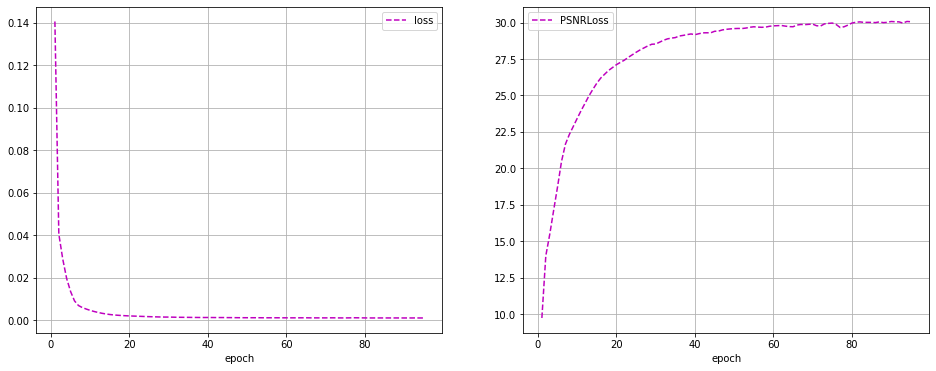

maximum PSNRLoss: 30.0729
minimum loss: 0.000987


In [10]:
import helper
helper.plot_model(hist,size=(16,6))

x = max(hist.history['PSNRLoss'])
print(f"maximum PSNRLoss: {x:.4f}")
x = min(hist.history['loss'])
print(f"minimum loss: {x:f}")

## Testlauf

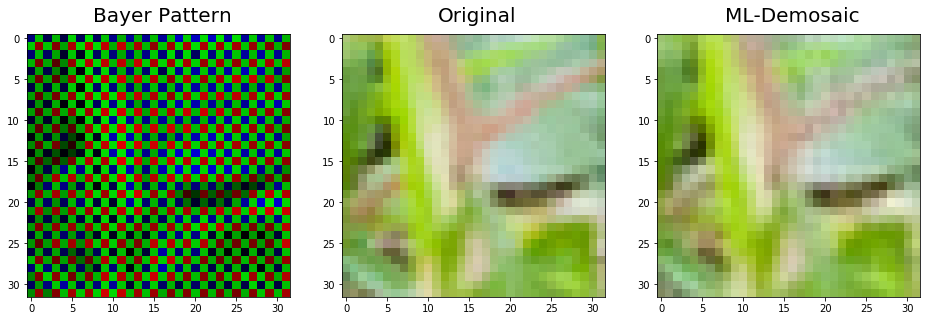

In [11]:
plt.figure(figsize=(16,16*3))

i = 15

plt.subplot(1,3,1)
plt.imshow(train_a[i],interpolation="nearest")
plt.text(16,-2,"Bayer Pattern",fontsize=20,horizontalalignment='center')

plt.subplot(1,3,2)
plt.imshow(train_b[i],interpolation="nearest")
plt.text(16,-2,"Original",fontsize=20,horizontalalignment='center')


plt.subplot(1,3,3)
decoded = model.predict(train_a[i:i+1])
decoded = np.clip(decoded,0,1)
plt.imshow(decoded[0])
plt.text(16,-2,"ML-Demosaic",fontsize=20,horizontalalignment='center')

plt.show()